# Geometric inputs

## Content
- input formats
    - dict
    - plantGL
    - fichier VGX
    - grille de voxels
    - table MTG de adelwheat
- organization levels: species and organs
- stems management
- geometric transformations

## Introduction
The main purpose of this tool was to merge several geometric scenes in various formats and apply a radiative modelling on it. Here, we will precise the different possiblities for manipulating geometry.

In [1]:
from lightvegemanager.tool import LightVegeManager
from pgljupyter import SceneWidget

In [3]:
# Environment parameters for this notebook
longitude = 2.
latitude = 46.
timezone = 1
coordinates = [latitude, longitude, timezone]
infinite = False
reflected = False
direct = False
diffuse = True
sky = "turtle46" 

environment = {
                "coordinates": coordinates ,
                "infinite": infinite,
                "reflected": reflected,
                "direct": direct,
                "diffuse": diffuse,
                "sky": sky
                }

## Inputs Formats
In this section, we won't present single triangle and list of triangles as input geometry, as they were present in the `tool_basics.ipynb` notebook. Also, these two formats can be direct inputs of the `geometry` argument of the `build` method, unlike the following formats which needs to be included in a list, such as:

```python
geometry = { "scenes": [scene1, scene2, ...] }
```


### dict of triangles
A mesh of triangles can be represented as a dict, where each key is an organ ID and its value, a list of triangles belonging to the organ. A triangle is a list of a 3 vertices represented by `(x,y,z)`points.

In this example, we will generate random 3D triangles for 3 differents organs.

In [4]:
from lightvegemanager.trianglesmesh import random_triangle_generator

spheresize = (10., 2.)
organized_triangles = {
    111: [random_triangle_generator(spheresize=spheresize, worldsize=(0,20)) for i in range(20)],
    222: [random_triangle_generator(spheresize=spheresize, worldsize=(20,50)) for i in range(30)],
    333: [random_triangle_generator(spheresize=spheresize, worldsize=(50,100)) for i in range(10)],
}

Input geometry looks like:

In [5]:
geometry = {
    "scenes": [organized_triangles]
}

Then, we compute lighting and run a visualization of the scene.

Note: `elements_outputs` method will return a Dataframe where results are integrated on each organ.

In [6]:
lighting = LightVegeManager(lightmodel="caribu", environment=environment)
lighting.build(geometry=geometry)

# compute the lighting
energy = 500.
hour = 15
day = 264
lighting.run(energy=energy, hour=hour, day=day)
print(lighting.elements_outputs)
SceneWidget(lighting.plantGL_light(), 
            position=(-50.0, -50.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 100, 
            axes_helper=True)

   Day  Hour  Organ  VegetationType         Area    par Eabs      par Ei
0  264    15    111               0   711.771321  296.177789  348.444457
1  264    15    222               0  1156.884311  306.768543  360.904168
2  264    15    333               0   654.523573  366.530439  431.212282


SceneWidget(axes_helper=True, scenes=[{'id': '9RHpyfpxffDxoGLlkL287MFRR', 'data': b'x\xda\x85\x9ayX\x14W\xd6\x…

### PlantGL scene
A plantGL Scene is a list of plantGL Shape which can be considered as organ. The ID of the plantGL Shape are stored as organs ID.

In [7]:
import openalea.plantgl.all as pgl

pgl_scene = pgl.Scene([pgl.Shape(pgl.Box(), pgl.Material(), 888), 
                        pgl.Shape(pgl.Translated((0,0,1), pgl.Cylinder()), pgl.Material(), 999)])

In [8]:
geometry = {
    "scenes": [pgl_scene]
}
lighting = LightVegeManager(lightmodel="caribu", environment=environment)
lighting.build(geometry=geometry)
lighting.run(energy=energy, hour=hour, day=day)
print(lighting.elements_outputs)
SceneWidget(lighting.plantGL_light(), 
            position=(0.0, 0.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 5, 
            axes_helper=True)

   Day  Hour  Organ  VegetationType      Area    par Eabs      par Ei
0  264    15    888               0  6.000000  159.643042  187.815343
1  264    15    999               0  4.475681  185.076017  217.736490


SceneWidget(axes_helper=True, scenes=[{'id': '8kU7diEsaj9G3BXsKdlxCbLNN', 'data': b'x\xda\x95\x99\xddn\x1bE\x1…

### VGX file

The tool can read a VGX file as an input entry. It extracts triangles which are considered as leaves, following its colors, if Red != 42 . All triangles are stored in the same organ, where its ID is set to 0.

In [9]:
import os

vgx_path = os.path.join(os.path.dirname(os.path.abspath("")), "data", "NICatObs1P2.vgx")
vgx_path

'C:\\Users\\mwoussen\\cdd\\codes\\dev\\lightvegemanager\\data\\NICatObs1P2.vgx'

In [13]:
geometry = {
    "scenes": [vgx_path]
}
lighting = LightVegeManager(lightmodel="caribu", environment=environment)
lighting.build(geometry=geometry)
lighting.run(energy=energy, hour=hour, day=day)
print(lighting.elements_outputs)
SceneWidget(lighting.plantGL_light(), 
            position=(0.0, 0.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 100, 
            axes_helper=True)

   Day  Hour  Organ  VegetationType         Area    par Eabs      par Ei
0  264    15      0               0  6062.836763  193.704509  227.887658


SceneWidget(axes_helper=True, scenes=[{'id': 'HLu9lkkmKusXapCESDnuJx4VP', 'data': b'x\xda\x94\x9d\x07|U\xc5\xb…

### Grid of voxels

A voxel grid is represented as a dict of two entries:
- `"LA"` corresponding to leaf area, is a table (`numpy.array`) of dimension $\text{number of species} \times \text{number of z layers} \times \text{number of x layers} \times \text{number of y layers} $
- `"distrib"` corresponding to leaf angle distribution, is a list of list, where is entered a leaf angle distribution for each specy

Grid dimensions and voxel size are set in the input parameters of RATP.

In [14]:
import numpy

l_scene = {"LA": numpy.ones([2, 3, 4, 4]), "distrib": [[0.5, 0.5], [0.3, 0.7]]}

In [16]:
geometry = {
    "scenes": [vgx_path]
}
ratp_parameters = {
    "voxel size" : [20.] * 3
}
lighting = LightVegeManager(lightmodel="ratp", environment=environment, lightmodel_parameters=ratp_parameters)
lighting.build(geometry=geometry)
lighting.run(energy=energy, hour=hour, day=day)
print(lighting.elements_outputs)
SceneWidget(lighting.plantGL_light(printtriangles=False, printvoxels=True), 
            position=(0.0, 0.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 100, 
            axes_helper=True)

     Day  Hour  Organ  VegetationType         Area        PARa  Intercepted  \
0  264.0  15.0      0               1  6062.836763  307.604456   215.922903   

   Transmitted   SunlitPAR  SunlitArea   ShadedPAR  ShadedArea  
0   215.922903  307.604461  252.377915  307.604461  126.601372  


SceneWidget(axes_helper=True, scenes=[{'id': 'OgKLbEOYkRT69libXrZkXUjuC', 'data': b'x\xda\x95XMh]E\x14\xbe4\x8…

### MTG object from adelwheat

Finally, you can also give a MTG object with a `"scene"` property. The package adelwheat offers such objects.

In [17]:
from alinea.adel.adel_dynamic import AdelDyn
from alinea.adel.echap_leaf import echap_leaves
INPUTS_DIRPATH = os.path.join(os.path.dirname(os.path.abspath("")), "data")
adel_wheat = AdelDyn(seed=1, scene_unit="m", leaves=echap_leaves(xy_model="Soissons_byleafclass"))
g = adel_wheat.load(dir=INPUTS_DIRPATH)

In [18]:
geometry = {
    "scenes": [g]
}
lighting = LightVegeManager(lightmodel="caribu", environment=environment)
lighting.build(geometry=geometry)
lighting.run(energy=energy, hour=hour, day=day)
print(lighting.elements_outputs)
SceneWidget(lighting.plantGL_light(), 
            position=(0.0, 0.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 0.1, 
            axes_helper=True)

   Day  Hour  Organ  VegetationType      Area    par Eabs      par Ei
0  264    15     19               0  0.000228  159.208612  187.304249
1  264    15     34               0  0.000013   80.953500   95.239412
2  264    15    813               0  0.000194  385.317031  453.314154
3  264    15    814               0  0.000240  367.646906  432.525772
4  264    15     51               0  0.000284  347.458387  408.774573


SceneWidget(axes_helper=True, scenes=[{'id': 'nOBWAHxiPOAKSUmQc0cHKQkiR', 'data': b'x\xda\x95\x9a{pUW\x15\xc6/…

### RATP inputs
All the above scenes can be geometric inputs if the lightmodel argument is set to `"ratp"`.

In [21]:
geometry = {
    "scenes": [g]
}
lighting = LightVegeManager(lightmodel="ratp", environment=environment)
lighting.build(geometry=geometry)
lighting.run(energy=energy, hour=hour, day=day)
print(lighting.elements_outputs)
SceneWidget(lighting.plantGL_light(printvoxels=True), 
            position=(0.0, 0.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 0.1, 
            axes_helper=True)

     Day  Hour  Organ  VegetationType      Area        PARa  Intercepted  \
0  264.0  15.0     19               1  0.000228  435.713379     0.000693   
1  264.0  15.0     34               1  0.000013  435.713379     0.000693   
2  264.0  15.0    813               1  0.000194  435.713379     0.000693   
3  264.0  15.0    814               1  0.000240  441.368498     0.000288   
4  264.0  15.0     51               1  0.000284  435.713379     0.000693   

   Transmitted   SunlitPAR  SunlitArea   ShadedPAR  ShadedArea  
0     0.000693  435.713379    0.000776  435.713379    0.000019  
1     0.000693  435.713379    0.000776  435.713379    0.000019  
2     0.000693  435.713379    0.000776  435.713379    0.000019  
3     0.000288  441.368498    0.000322  441.368498    0.000007  
4     0.000693  435.713379    0.000776  435.713379    0.000019  


SceneWidget(axes_helper=True, scenes=[{'id': 'wctv0d7i6YHequCnJz21Y8umG', 'data': b'x\xda\x95\x9a\x0bpT\xd5\x1…

## Organizing the inputs

They are two levels of possible organization:
- species
- organs

Each triangle are bound to a specy ID and a organ ID. Each specy is represented as a input scene. The organs ID are set inside each scene depending on its format.

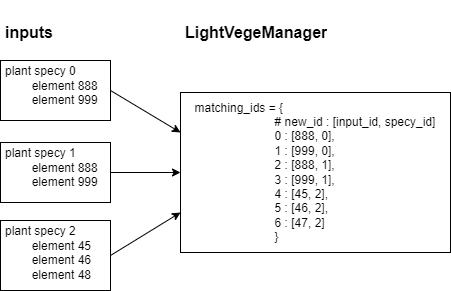

An example with several scenes with the same organs ID and CARIBU.

In [22]:
scene1 = {
    111: [random_triangle_generator(spheresize=spheresize) for i in range(20)],
    222: [random_triangle_generator(spheresize=spheresize) for i in range(30)],
    333: [random_triangle_generator(spheresize=spheresize) for i in range(10)],
}

scene2 = {
    111: [random_triangle_generator(spheresize=spheresize) for i in range(20)],
    222: [random_triangle_generator(spheresize=spheresize) for i in range(30)],
    333: [random_triangle_generator(spheresize=spheresize) for i in range(10)],
}

scene3 = {
    111: [random_triangle_generator(spheresize=spheresize) for i in range(20)],
    222: [random_triangle_generator(spheresize=spheresize) for i in range(30)],
    333: [random_triangle_generator(spheresize=spheresize) for i in range(10)],
}

We have 3 species

In [23]:
scenes = [scene1, scene2, scene3]
geometry = { "scenes": scenes }

In [24]:
lighting = LightVegeManager(lightmodel="caribu")
lighting.build(geometry=geometry)

# compute the lighting
energy = 500.
hour = 15
day = 264
lighting.run(energy=energy, hour=hour, day=day)
print(lighting.elements_outputs)

   Day  Hour  Organ  VegetationType         Area    par Eabs      par Ei
0  264    15    111               0   865.848719  367.620782  432.495038
1  264    15    222               0   904.093391  343.903742  404.592638
2  264    15    333               0   500.476649  374.891932  441.049332
3  264    15    111               1   719.501340  330.624848  388.970410
4  264    15    222               1  1023.379192  351.641676  413.696090
5  264    15    333               1   129.105369  391.022326  460.026266
6  264    15    111               2  1047.414777  335.930702  395.212591
7  264    15    222               2  1174.044647  349.124635  410.734865
8  264    15    333               2   521.903258  361.052748  424.767939


In [25]:
SceneWidget(lighting.plantGL_light(), 
            position=(-50.0, -50.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 100, 
            axes_helper=True)

SceneWidget(axes_helper=True, scenes=[{'id': 'sNiVT3L9ABichdb2gAyBsVr2f', 'data': b'x\xda\x85}\x07|\x8d\xd7\xf…

The two level organization are also kept with RATP

In [27]:
lighting = LightVegeManager(lightmodel="ratp")
lighting.build(geometry=geometry)

energy = 500.
hour = 15
day = 264
lighting.run(energy=energy, hour=hour, day=day)
print(lighting.elements_outputs)

     Day  Hour  Organ  VegetationType         Area        PARa  Intercepted  \
0  264.0  15.0    111               1   865.848719  444.431609   438.050846   
1  264.0  15.0    222               1   904.093391  439.138654   508.370824   
2  264.0  15.0    333               1   500.476649  438.358519   466.758357   
3  264.0  15.0    111               2   719.501340  441.984838   374.664274   
4  264.0  15.0    222               2  1023.379192  436.324817   446.932608   
5  264.0  15.0    333               2   129.105369  442.768841   373.148804   
6  264.0  15.0    111               3  1047.414777  437.256257   728.403508   
7  264.0  15.0    222               3  1174.044647  443.465415   536.007093   
8  264.0  15.0    333               3   521.903258  432.082470   816.087594   

   Transmitted   SunlitPAR  SunlitArea   ShadedPAR  ShadedArea  
0   438.050846  450.722334  463.402916  356.222905   49.407779  
1   508.370824  446.126727  538.617195  351.627301   58.372064  
2   466.758357

c:\users\mwoussen\cdd\codes\dev\lightvegemanager\src\lightvegemanager\outputs.py:255: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  trianglesoutputs = pandas.merge(dftriangles, voxels_outputs)


## Stems

If there are stems elements in the inputs, you can precise their ID and the tool will manage them, depending on the lightmodel:
- with CARIBU, the optical parameters associated to the organ won't have a transmission value (rays won't cross the triangle)
- with RATP, stems are separated in a new specy with its own leaf angle distribution and their leaf area is divided by 2

We reuse the wheat geometry given by adelwheat

In [28]:
geometry = {
    "scenes": [g]
}

stems are stored in list where each element is a 2-tuple `(organ ID, specy ID)`

In [29]:
stems = [(19, 0), (34, 0)]
geometry.update({"stems id": stems})

In [31]:
lighting = LightVegeManager(lightmodel="caribu")
lighting.build(geometry=geometry)
SceneWidget(lighting.plantGL_nolight(), 
            position=(0.0, 0.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 0.1, 
            axes_helper=True)

SceneWidget(axes_helper=True, scenes=[{'id': 'IsRMwySFZ9ZohWaXTXeDJB3NN', 'data': b'x\xda\x95\x9a{\x90\x14\xd5…

In [32]:
lighting.run(energy=energy, hour=hour, day=day)
print(lighting.elements_outputs)
SceneWidget(lighting.plantGL_light(), 
            position=(0.0, 0.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 0.1, 
            axes_helper=True)

   Day  Hour  Organ  VegetationType      Area    par Eabs      par Ei
0  264    15     19               0  0.000228  194.070089  215.633432
1  264    15     34               0  0.000013   93.806573  104.229526
2  264    15    813               0  0.000194  458.967637  539.961926
3  264    15    814               0  0.000240  392.729426  462.034618
4  264    15     51               0  0.000284  350.644177  412.522561


SceneWidget(axes_helper=True, scenes=[{'id': 'X6MEhdoPOJgZ1bvsYLGzPEHsk', 'data': b'x\xda\x95\x9a{p\x15\xd5\x1…

## Geometric transformations

You can apply geometric transformations on some of the inputs scenes. We have currently 3 available transformations
- translation by a vector
- rescale by a factor or following scenes metric unit
- rotation on the xy plane

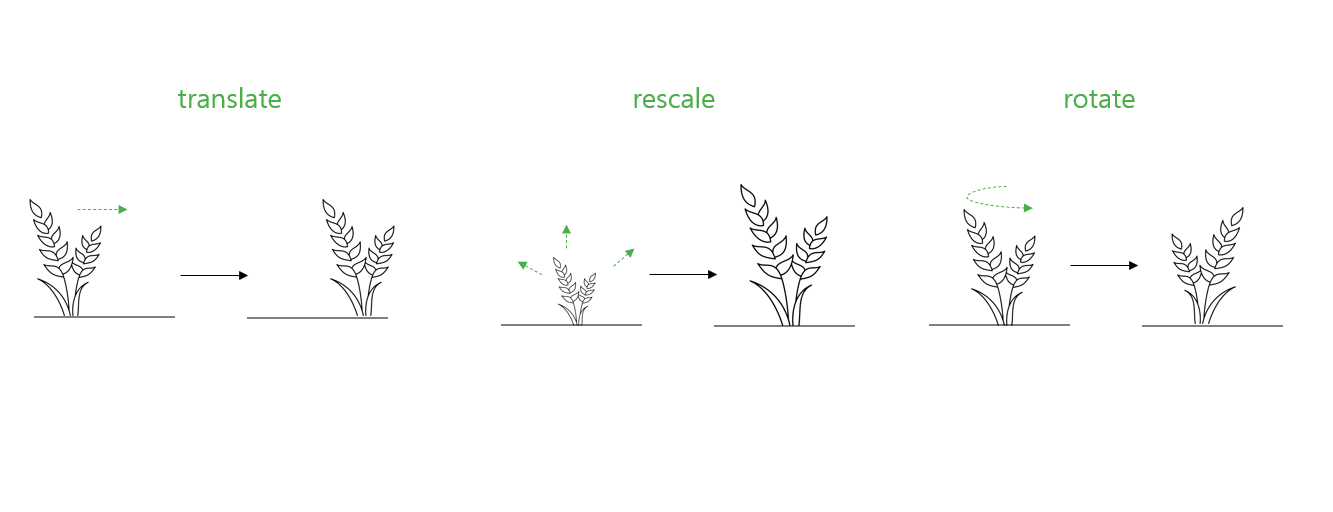

Transformations are stored in a dict, which is stored at key `"transformations"` in the geometry entry. Structure of transformations :

```python
transformations = {
    "scenes unit": { specy ID: "metric unit", ...},
    "rescale": { specy ID: float, ...},
    "translate": { specy ID: 3-tuple (x,y,z), ...},
    "xyz orientation":  { specy ID: "x+ = NEWS", ...},
}
```

#### Main scenes

In [33]:
spheresize = (2., 1.)
scene1 = {
    0: [random_triangle_generator(spheresize=spheresize, worldsize=(0,10)) for i in range(20)]
}
scene2 = {
    0: [random_triangle_generator(spheresize=spheresize, worldsize=(10,20)) for i in range(20)]
}

geometry = {"scenes": [scene1, scene2] }

In [34]:
lighting = LightVegeManager(lightmodel="caribu")
lighting.build(geometry=geometry)
SceneWidget(lighting.plantGL_nolight(), 
            position=(0.0, 0.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 50., 
            axes_helper=True)

SceneWidget(axes_helper=True, scenes=[{'id': 'x2kF5tS9AndLssWwjlaOy3kLL', 'data': b'x\xda\x8d\x99{X\x95U\x16\x…

### Translate

The translation vector is a 3-tuple (x,y,z). Transformations is a dict in the geometry dict.

In [35]:
tvec = (10., -10., 10.)
transformations = {
    "translate": {
        0: tvec
    }
}
geometry = {"scenes": [scene1, scene2] , "transformations": transformations}

In [36]:
lighting = LightVegeManager(lightmodel="caribu")
lighting.build(geometry=geometry)
SceneWidget(lighting.plantGL_nolight(), 
            position=(0.0, 0.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 50., 
            axes_helper=True)

SceneWidget(axes_helper=True, scenes=[{'id': 'zrGQj63NhCe4kJTSuqwWzqwIq', 'data': b'x\xda\x8d\x99\x0bTT\xe5\x1…

### Rescale following metric unit

You can precise the metric unit of each scene from this list: `"mm", "cm", "dm", "m", "dam", "hm", "km"`. By default the merged scene is in m but you can change its unit when you create an instance.

In [37]:
transformations = {
    "scenes unit": {
        0: "dm"
    }
}
geometry = {"scenes": [scene1, scene2] , "transformations": transformations}

In [38]:
lighting = LightVegeManager(lightmodel="caribu", main_unit="m")
lighting.build(geometry=geometry)
SceneWidget(lighting.plantGL_nolight(), 
            position=(0.0, 0.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 50., 
            axes_helper=True)

SceneWidget(axes_helper=True, scenes=[{'id': 'HMlA6Yj33bkxnz21kiTM7u5Do', 'data': b'x\xda\x8d\x99{X\x95U\x16\x…

### Rescale by a scalar factor

In [39]:
transformations = {
    "rescale": {
        0: 2.,
    }
}
geometry = {"scenes": [scene1, scene2] , "transformations": transformations}

In [40]:
lighting = LightVegeManager(lightmodel="caribu")
lighting.build(geometry=geometry)
SceneWidget(lighting.plantGL_nolight(), 
            position=(0.0, 0.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 50., 
            axes_helper=True)

SceneWidget(axes_helper=True, scenes=[{'id': 'gMUutGWi4Dc5iGozgvVOqeQ3B', 'data': b'x\xda\x8d\x99{T\x95U\x1a\x…

### Rotate

Finally, you can also rotate the scene around the z axis, in order to match the x+ convention for each input scene. You have the choice between:
- `"x+ = N"`
- `"x+ = S"`
- `"x+ = E"`
- `"x+ = W"`

The merged scene convention is x+ = N, which the convention in RATP and CARIBU.

In [41]:
transformations = {
    "xyz orientation": {
        0: "x+ = S",
        1: "x+ = E",
    }
}
geometry = {"scenes": [scene1, scene2] , "transformations": transformations}

In [42]:
lighting = LightVegeManager(lightmodel="caribu")
lighting.build(geometry=geometry)
SceneWidget(lighting.plantGL_nolight(), 
            position=(0.0, 0.0, 0.0), 
            size_display=(600, 400), 
            plane=True, 
            size_world = 50., 
            axes_helper=True)

SceneWidget(axes_helper=True, scenes=[{'id': 'nZK2fX8ANhsqBsN8J5jKjSQ2I', 'data': b'x\xda\x8d\x99{TUU\x1e\xc7o…